#  (MAS473) Introduction to Artificial Intelligence with Mathematics
# Homework #1: Introduction to the Neural Network

TA : Munsik Kim ,rlarhwh2@kaist.ac.kr

Due Date : 22.09.2023(Fri), 23:59 PM

In HW1, you should submit following file:
- `MAS473_HW1_StudentID.ipynb`: a **completed** version of this IPython notebook.
  - **Do NOT clear** your outputs (ex. plots, outputs, etc.).  

First of all, you should copy the original Colab notebook into your Google drive.
  - Sign in Google.
  - Click `File` in the left top on menu and select `Save a copy in Drive..`.
- Then you can edit your copied notebook in Google Colab!
  - Fill in the `Implementation Here` marked part to run appropriately.
  - Each code cell will be executed when you click the play button left side of the cell (or press `Ctrl+Enter`).
- Download your copied notebook file (`.ipynb` file) to your local and rename it as the following:

**Please submit the notebook file (without compressing) with the name like below:**

**MAS473_HW1_StudentID.ipynb**

**ex) MAS473_HW1_20191234.ipynb**

---



# 1. Prerequisites

The purpose of this homework is to practice for implementing some basic neural networks.

You can use following packages in this HW:

##  Data Loading

### Download data
Gathering proper dataset for given tasks is a starting point of solving a deep learning problem.
In our tutorial, we use ```torchvision.datasets``` class, which provides diverse benchmark datasets for various deep learning tasks. The following are some main parameters of the class.
* **root**(string) - Root directory of dataset
* **train**(bool) - If true, creates dataset for training, otherwise for test.
* **download**(bool) - If false, dataset is not downloaded again.
* **transform**(callable) - A function/transform that takes in an PIL image and returns a transformed version.

MNIST data contains 60,000 training and 10,000 test images. They are images of numbers and labels of the numbers.

https://pytorch.org/docs/stable/torchvision/datasets.html#torchvision.datasets.MNIST

If you want to use your own data, we prepare the data with csv file (obviously other types ok) and upload into the Google drive and set the file directory.

In [3]:
!pip install torch torchvision

In [4]:
import torchvision
import torchvision.transforms as transforms

trainset_mnist = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
testset_mnist = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 266851376.08it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 43231867.89it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 129194137.91it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 24613086.26it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



###Dataloader

After the dataset is prepared, we need an appropriate tool to process the data.
We use ```torch.utils.data.DataLoader``` module for the purpose.


* **dataset**(Dataset) - dataset.
* **batch_size**(int) - how many samples per mini-batch to load.
* **sampler**(Sampler) - defines the strategy to draw samples from the dataset.

In our case, sampler will be used to train a part of the dataset. This will speed up the process. If you want to run the code with more samples, increase ```ratio_split = data_ratio``` ($< 1$) or set ```sampler = None```.

https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader


In [5]:
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

def dataset_sampler(ratio_split, len_dataset):

    # set parameter
    offset_split = int(np.floor(ratio_split * len_dataset))
    indices = list(range(len_dataset))

    # shuffle
    np.random.shuffle(indices)

    # set samplers
    sampler = SubsetRandomSampler(indices[:offset_split])

    return sampler

data_ratio = 0.1
batch_size = 8


train_sampler = dataset_sampler(data_ratio, len(trainset_mnist))
train_loader = DataLoader(dataset = trainset_mnist, batch_size = batch_size, sampler=train_sampler)
test_loader = DataLoader(dataset = testset_mnist, batch_size = batch_size)

### Visualizer
Let us show what the dataset contains and how the dataloader works.
The results should show what the images are.

        4       3       1       9       5       9       6       6


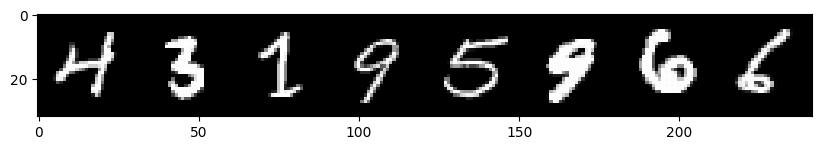

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

# get some images

dataiter = iter(train_loader)
images, labels = next(dataiter)

# functions setting to show an image

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.cmap'] = 'gray'

# show images
plt.imshow(torchvision.utils.make_grid(images).permute(1,2,0))
# print labels
print('  '+' '.join('%7s' % labels[j].item() for j in range(8)))


#Implemeting a neural network


## 1. Define a network
### Design your network - multiclass classifier

Our final goal is to obtain a neural network that distinguish images of numbers.
* When the input of the network is an image of a number, the output should be a vector of 10 elements, which $i$th component representing probability of the given input being an image of number $i$ - like logistic regression.  


* Whether elements in the vector satisfy the axiom of probability(i.e., $0\le p_i\le 1, \sum p_i =1$) does not matter right now. We will see why.


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MyNetwork(nn.Module):
    def __init__(self, params):

        super(MyNetwork, self).__init__()
        self.data_size = params['data_size']
        self.hidden_units = params['hidden_units']
        self.layers = nn.Sequential(
            nn.Linear(self.data_size, self.hidden_units),
            nn.ReLU(),
            nn.Linear(self.hidden_units, 10))

    def forward(self, x):

        return F.softmax(self.layers(x), dim=1)

## 2. Loss function
We designed a neural network with parameters. Then, a loss function is used to optimize parameters. One of basic options is **cross entropy loss**. Minimizing cross-entropy loss is equivalent to minimizing KL divergence, which measures the difference between two distributions.

$$H(p,q) = -\sum p(x) \log q(x)$$

In our case, we would get $q_i, i=0,...,9$ as an output of network. The target distribution $p$ is, $p_i(x) = 1$ if $x$ is an image of number $i$, and $p_i(x) = 0$ otherwise. That is, $p(y) = 1$ for some $y$, $H(p,q) = -\log q(y)$


Before getting to an example of computing cross-entropy loss using ```torch.nn```, the function is implemented in reality as following.

$$loss(\text{output}, label) = -\text{output}[label] + \log \Big( \sum_{i: \text{ possible labels}} \exp(\text{output} (i)) \Big) .$$

As you see, the only difference is softmax function in ```nn.CrossEntropyLoss```. Therefore, we do not have to worry whether the output is larger than 1, or even less than 0. Note that all the computation is done parallel, sample-wise in mini-batch and then averaged.

Here is an example of the function, classification of 4 categories, two samples in a mini-batch.
Check the computed loss by ```criterion``` function. The result from concatenated one is an average of other two.


https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss

In [8]:
criterion = nn.CrossEntropyLoss()
a = torch.tensor([[3, 0.1, -7, 0]])
b = torch.tensor([[0.3, 0.1, -20, 100]])
c = torch.cat((a,b))
print(c)
print(criterion(a, torch.tensor([0])).item())
print(criterion(b, torch.tensor([2])).item())
print(criterion(c, torch.tensor([0,2])).item())

tensor([[  3.0000,   0.1000,  -7.0000,   0.0000],
        [  0.3000,   0.1000, -20.0000, 100.0000]])
0.09971469640731812
120.0
60.04985809326172


## 3. Train
### Optimizer
Let us optimize our parameters of network with the loss function. As soon as we compute loss of output of network, autograd leaves mark of operations, so ```backward()```
computes a gradient in parameter space.
This is what we have learned in pytorch tutorial previously. ```torch.optim``` class is initialized with parameters of a network, and ```step()``` method modifies parameters simultaneously by the computed gradient. Next, using ```zero_grad()```, we delete the recorded gradient for next optmization step. We will see how these items are organized in training step.

### Hyperparameter
Before diving into the training process, we have to determine hyperparameters. For example, the number of epochs for training, a optimizer to employ, and magnitude of learning rate for the optimizer. Of course, the number of samples and images to load in one mini-batch are all hyperparameters - even designing network architecture.

The following are some hyperparameters that we mainly adjust during training.
*  **epoch** : the number of iterations for the whole dataset in gradient descent
*   **loss_show_freq** : interval of recording average loss during training
*   **learning_rate** : step size of gradient descent (parameter of optimizer)

In [9]:
# hyperparameters
epoch = 300
loss_show_freq = 2
learning_rate = 0.005

The following code calls a network, a loss, and an optimizer. Then, the network is trained. After the training is finished, the graph of average loss appears.


>> TRAIN 
cuda:0  will be used.

>> 2012 second / 33 minutes expected 
Epoch[2] Loss = 2.286671
Epoch[4] Loss = 2.222584
Epoch[6] Loss = 2.087291
Epoch[8] Loss = 1.924220
Epoch[10] Loss = 1.830667
Epoch[12] Loss = 1.788128
Epoch[14] Loss = 1.759451
Epoch[16] Loss = 1.721871
Epoch[18] Loss = 1.697424
Epoch[20] Loss = 1.681323
Epoch[22] Loss = 1.670154
Epoch[24] Loss = 1.661915
Epoch[26] Loss = 1.655667
Epoch[28] Loss = 1.650643
Epoch[30] Loss = 1.646307
Epoch[32] Loss = 1.642632
Epoch[34] Loss = 1.639565
Epoch[36] Loss = 1.636778
Epoch[38] Loss = 1.634207
Epoch[40] Loss = 1.631923
Epoch[42] Loss = 1.629774
Epoch[44] Loss = 1.627965
Epoch[46] Loss = 1.626166
Epoch[48] Loss = 1.624637
Epoch[50] Loss = 1.623062
Epoch[52] Loss = 1.621687
Epoch[54] Loss = 1.620380
Epoch[56] Loss = 1.618927
Epoch[58] Loss = 1.617913
Epoch[60] Loss = 1.616641
Epoch[62] Loss = 1.615535
Epoch[64] Loss = 1.614229
Epoch[66] Loss = 1.611868
Epoch[68] Loss = 1.589410
Epoch[70] Loss = 1.578414
Epoch[72] Loss = 1.571

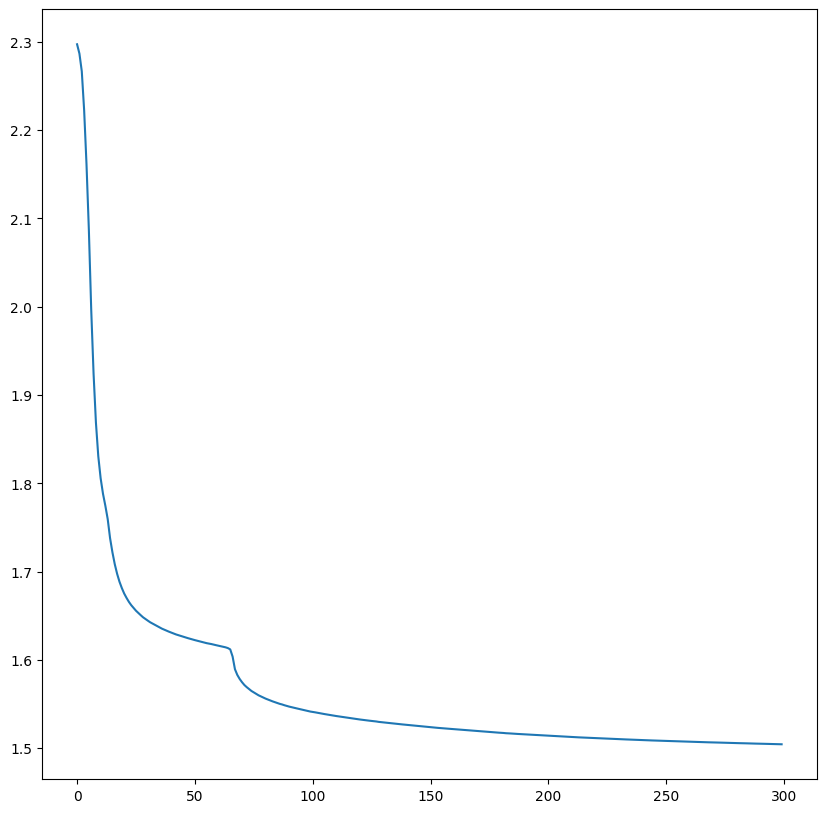

In [10]:
import time

print("\n>> TRAIN ")
params = {'data_size': 784,
         'hidden_units' : 256}
loss_arr=[]

device = torch.device("cuda:0" if(torch.cuda.is_available()) else "cpu")
print(device, " will be used.\n")

net = MyNetwork(params).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)


for i in range(epoch):
    loss_sum = 0
    if (i == 0):
        t1 = time.time()

    for j, [image, label] in enumerate(train_loader):
        # Get batch size.
        bs = image.size(0)
        # Flatten the image.
        image = image.view(bs, -1).to(device)
        label = label.to(device)
        optimizer.zero_grad()
        result = net.forward(image)
        loss = criterion(result, label)

        loss.backward()
        optimizer.step()

        loss_sum += loss.item()

    # Loss #######
    loss_mean = loss_sum * (batch_size / (data_ratio * (len(trainset_mnist))))
    loss_arr.append(loss_mean)
    if ((i+1)%loss_show_freq==0):
        print('Epoch[%d] Loss = %f'%((i+1), loss_mean))

    # time #######
    if (i == 0):
        t2 = time.time()
        duration = t2-t1
        train_time = duration * epoch
        print(">> %d second / %d minutes expected " % (train_time, train_time / 60))

plt.figure(1)
plt.plot(loss_arr)
plt.show()

## 4. Test
We can test performance of the trained network. Notice that we use another dataloader, ```test_loader```

In [11]:
print("\n>> TEST ")
net.eval()
correct = 0
total = 0

for image, label in test_loader:
    #image = Variable(image)#.cuda()
    bs = image.size(0)
    # Flatten the image.
    image = image.view(bs, -1).to(device)
    label = label.to(device)
    result = net(image)#.cuda()
    _, predicted = torch.max(result.data, 1)
    total += label.size(0)
    correct += (predicted == label).sum()#.cuda()).sum()
print(' Test Accuracy of the model on the 10000 test images:  %f %%' % (100 * correct / total))




>> TEST 
 Test Accuracy of the model on the 10000 test images:  92.220001 %


#  HOMEWORK

Using the above, you create a Fully Connected Neural Network or Convolutional Neural Network to learn the MNIST dataset.

Your network should satisfy


1.   the width of the neural network is larger than 2
2.   the test accuracy should exeed 94%.


Hint :



*   You can find a lot of examples in google or github. It is fine to adapt those examples in our model. but you should not copy them totally.
*   In the pytorch documents, you can find definitions of the parameters in pytorch. Please visit the official site.
*   For example, you can change **epoch**, **learning rate**, **loss function** , **structure of the neural networks** **,the size of the batch** , **optimizer** and so on. (For later Homeworks, I recommand you try to do these.
*   If you want to use another tools such as keras, tensorflow etc, it is ok but you have to explain the each code you wrote.



https://pytorch.org/docs/stable/index.html








In [120]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MyNetwork(nn.Module):
    def __init__(self, params):
        super(MyNetwork, self).__init__()
        self.data_size = params['data_size']
        self.hidden_units = params['hidden_units']

        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size = 3, padding = 1),   # 16 channels, size 28*28
            nn.MaxPool2d(kernel_size = 2, stride = 2),        # 16 channels, size 14*14
            nn.Conv2d(16, 16, kernel_size = 3, padding = 1),  # 16 channels, size 14*14
            nn.MaxPool2d(kernel_size = 2, stride = 2)         # 16 channels, size 7*7
        )

        self.layers2 = nn.Sequential(
            nn.ReLU(),
            nn.Linear(16 * 7  * 7, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        bs = x.size(0)
        x = x.view(bs, 1, 28, 28)  # Reshape
        x = self.conv(x)
        x = x.view(bs, -1)  # Flatten
        x = self.layers2(x)
        return F.softmax(x, dim=1)


In [116]:
# hyperparameters , you have to set proper hyperparameters. It is ok using the above.
epoch = 100
learning_rate = 0.01


>> TRAIN 
cuda:0  will be used.

>> 239 second / 3 minutes expected 
Epoch[2] Loss = 2.301121
Epoch[4] Loss = 2.297854
Epoch[6] Loss = 2.260806
Epoch[8] Loss = 1.749355
Epoch[10] Loss = 1.672717
Epoch[12] Loss = 1.654554
Epoch[14] Loss = 1.644141
Epoch[16] Loss = 1.634047
Epoch[18] Loss = 1.627081
Epoch[20] Loss = 1.618985
Epoch[22] Loss = 1.613602
Epoch[24] Loss = 1.611461
Epoch[26] Loss = 1.605747
Epoch[28] Loss = 1.601584
Epoch[30] Loss = 1.595787
Epoch[32] Loss = 1.593270
Epoch[34] Loss = 1.589011
Epoch[36] Loss = 1.587163
Epoch[38] Loss = 1.584126
Epoch[40] Loss = 1.580990
Epoch[42] Loss = 1.580659
Epoch[44] Loss = 1.578841
Epoch[46] Loss = 1.576262
Epoch[48] Loss = 1.574910
Epoch[50] Loss = 1.572238
Epoch[52] Loss = 1.568949
Epoch[54] Loss = 1.567781
Epoch[56] Loss = 1.565959
Epoch[58] Loss = 1.565190
Epoch[60] Loss = 1.564768
Epoch[62] Loss = 1.564439
Epoch[64] Loss = 1.563625
Epoch[66] Loss = 1.562344
Epoch[68] Loss = 1.560814
Epoch[70] Loss = 1.561465
Epoch[72] Loss = 1.56045

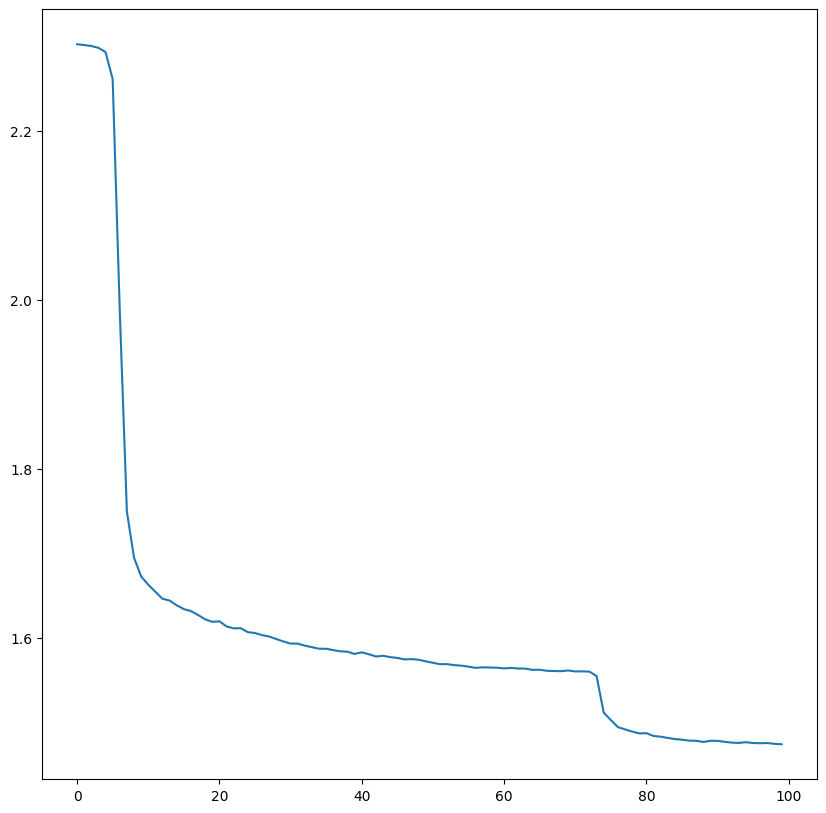

In [121]:
import time

print("\n>> TRAIN ")
params = {'data_size': 784,
         'hidden_units' : 256}
loss_arr=[]

device = torch.device("cuda:0" if(torch.cuda.is_available()) else "cpu")
print(device, " will be used.\n")

net = MyNetwork(params).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)


for i in range(epoch):
    loss_sum = 0
    if (i == 0):
        t1 = time.time()

    for j, [image, label] in enumerate(train_loader):
        # Get batch size.
        bs = image.size(0)
        # Flatten the image.
        image = image.view(bs, -1).to(device)
        label = label.to(device)
        optimizer.zero_grad()
        result = net.forward(image)
        loss = criterion(result, label)

        loss.backward()
        optimizer.step()

        loss_sum += loss.item()

    # Loss #######
    loss_mean = loss_sum * (batch_size / (data_ratio * (len(trainset_mnist))))
    loss_arr.append(loss_mean)
    if ((i+1)%loss_show_freq==0):
        print('Epoch[%d] Loss = %f'%((i+1), loss_mean))

    # time #######
    if (i == 0):
        t2 = time.time()
        duration = t2-t1
        train_time = duration * epoch
        print(">> %d second / %d minutes expected " % (train_time, train_time / 60))

plt.figure(1)
plt.plot(loss_arr)
plt.show()

In [122]:
print("\n>> TEST ")
net.eval()
correct = 0
total = 0

for image, label in test_loader:
    #image = Variable(image)#.cuda()
    bs = image.size(0)
    # Flatten the image.
    image = image.view(bs, -1).to(device)
    label = label.to(device)
    result = net(image)#.cuda()
    _, predicted = torch.max(result.data, 1)
    total += label.size(0)
    correct += (predicted == label).sum()#.cuda()).sum()
print(' Test Accuracy of the model on the 10000 test images:  %f %%' % (100 * correct / total))




>> TEST 
 Test Accuracy of the model on the 10000 test images:  96.209999 %
